This notebook contains the code to download and run machine learning models on the letter recognition data set that I am modelling for my dissertation. The results and graphs found in the final report were generated with this notebook.

In [1]:
# General
import urllib
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# Scikit learn 
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score

# Keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2

# Set random seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# Download the information file for the data set
info_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.names"
info_filename = "letter-recognition.names"
urllib.request.urlretrieve(info_url, info_filename)
with open(r'letter-recognition.names') as f:
    print(f.read())

# Manually create a list of column names for the data frame    
column_names = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 
                'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

1. Title: Letter Image Recognition Data 

2. Source Information
   -- Creator: David J. Slate
     -- Odesta Corporation; 1890 Maple Ave; Suite 115; Evanston, IL 60201
   -- Donor: David J. Slate (dave@math.nwu.edu) (708) 491-3867   
   -- Date: January, 1991

3. Past Usage:
   -- P. W. Frey and D. J. Slate (Machine Learning Vol 6 #2 March 91):
	"Letter Recognition Using Holland-style Adaptive Classifiers".

   	The research for this article investigated the ability of several
	variations of Holland-style adaptive classifier systems to learn to
	correctly guess the letter categories associated with vectors of 16
	integer attributes extracted from raster scan images of the letters.
	The best accuracy obtained was a little over 80%.  It would be
	interesting to see how well other methods do with the same data.

4. Relevant Information:

   The objective is to identify each of a large number of black-and-white
   rectangular pixel displays as one of the 26 capital letters in the English
 

In [3]:
# Download the data set
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
data_filename = "letter-recognition.data"
urllib.request.urlretrieve(data_url, data_filename)

# Create a dataframe using the data and column names
df = pd.read_csv(r'letter-recognition.data', sep=",", names=column_names)

# Data analysis

In [4]:
df.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lettr   20000 non-null  object
 1   x-box   20000 non-null  int64 
 2   y-box   20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   high    20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   x-bar   20000 non-null  int64 
 7   y-bar   20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybr   20000 non-null  int64 
 12  xy2br   20000 non-null  int64 
 13  x-ege   20000 non-null  int64 
 14  xegvy   20000 non-null  int64 
 15  y-ege   20000 non-null  int64 
 16  yegvx   20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


Mean count:  769.2307692307693
Standard deviation of counts:  22.724618457163782
Range of counts:  79
U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
N    783
Q    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
H    734
Z    734
Name: lettr, dtype: int64


Text(0, 0.5, 'Number of occurrences')

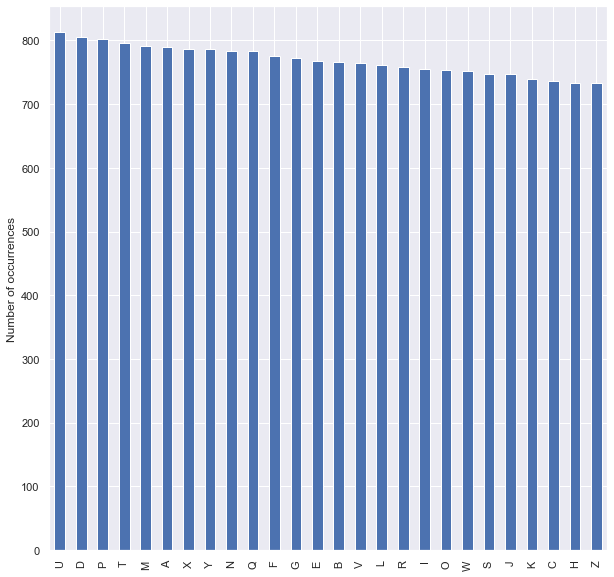

In [6]:
# View frequency of each letter in the data
letter_counts = df['lettr'].value_counts()
print("Mean count: ", np.mean(letter_counts))
print("Standard deviation of counts: ", np.std(letter_counts))
print("Range of counts: ", np.max(letter_counts) - np.min(letter_counts))
print(letter_counts)

# Plot the results
%matplotlib inline
plt.figure(figsize=(10,10))
letter_counts.plot(kind='bar')
plt.ylabel('Number of occurrences')

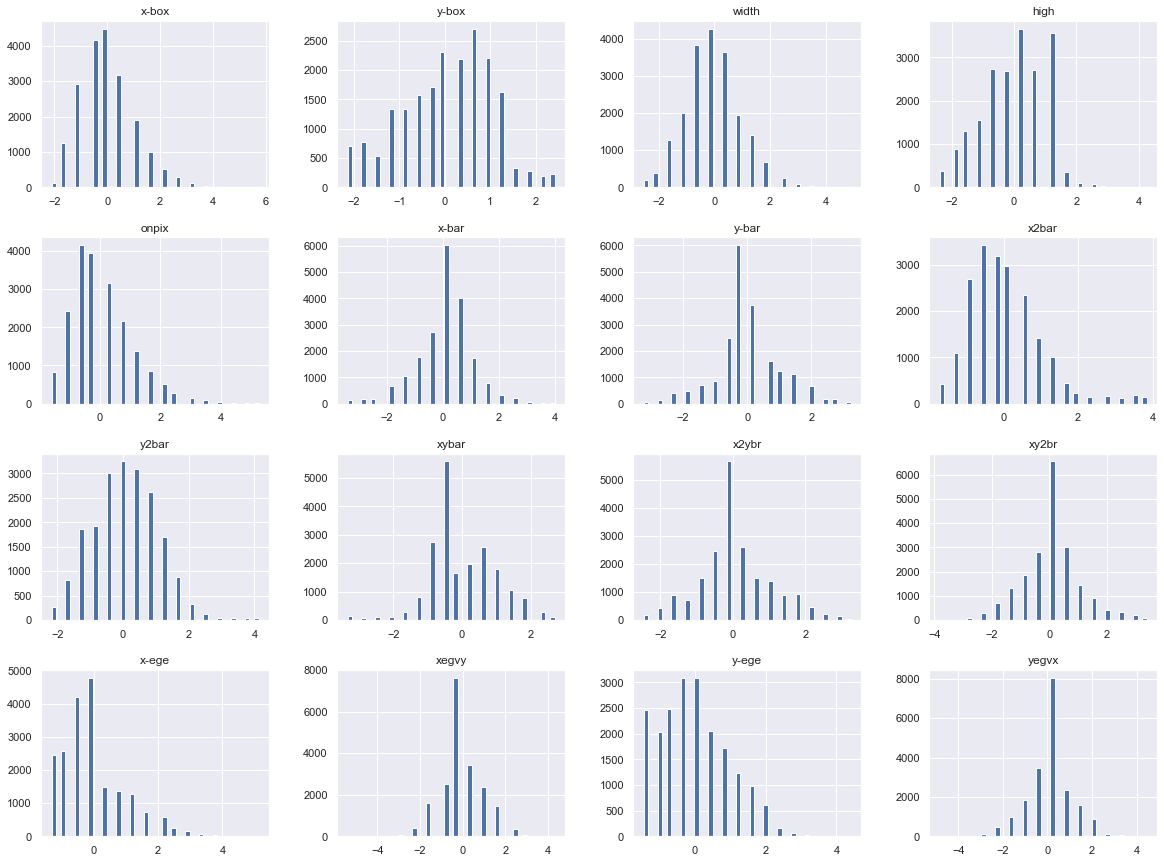

In [7]:
# Z-score standardiser
def standardise(x):
    return (x - x.mean()) / x.std()

# Standardise each covariate
for col in df.columns[1:]:
    df[col] = standardise(df[col])

# Plot historgrams of the covariate distributions
%matplotlib inline
df.hist(bins=45, figsize=(20,15))
plt.show()

C:\Users\etien\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\etien\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\etien\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\etien\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt str

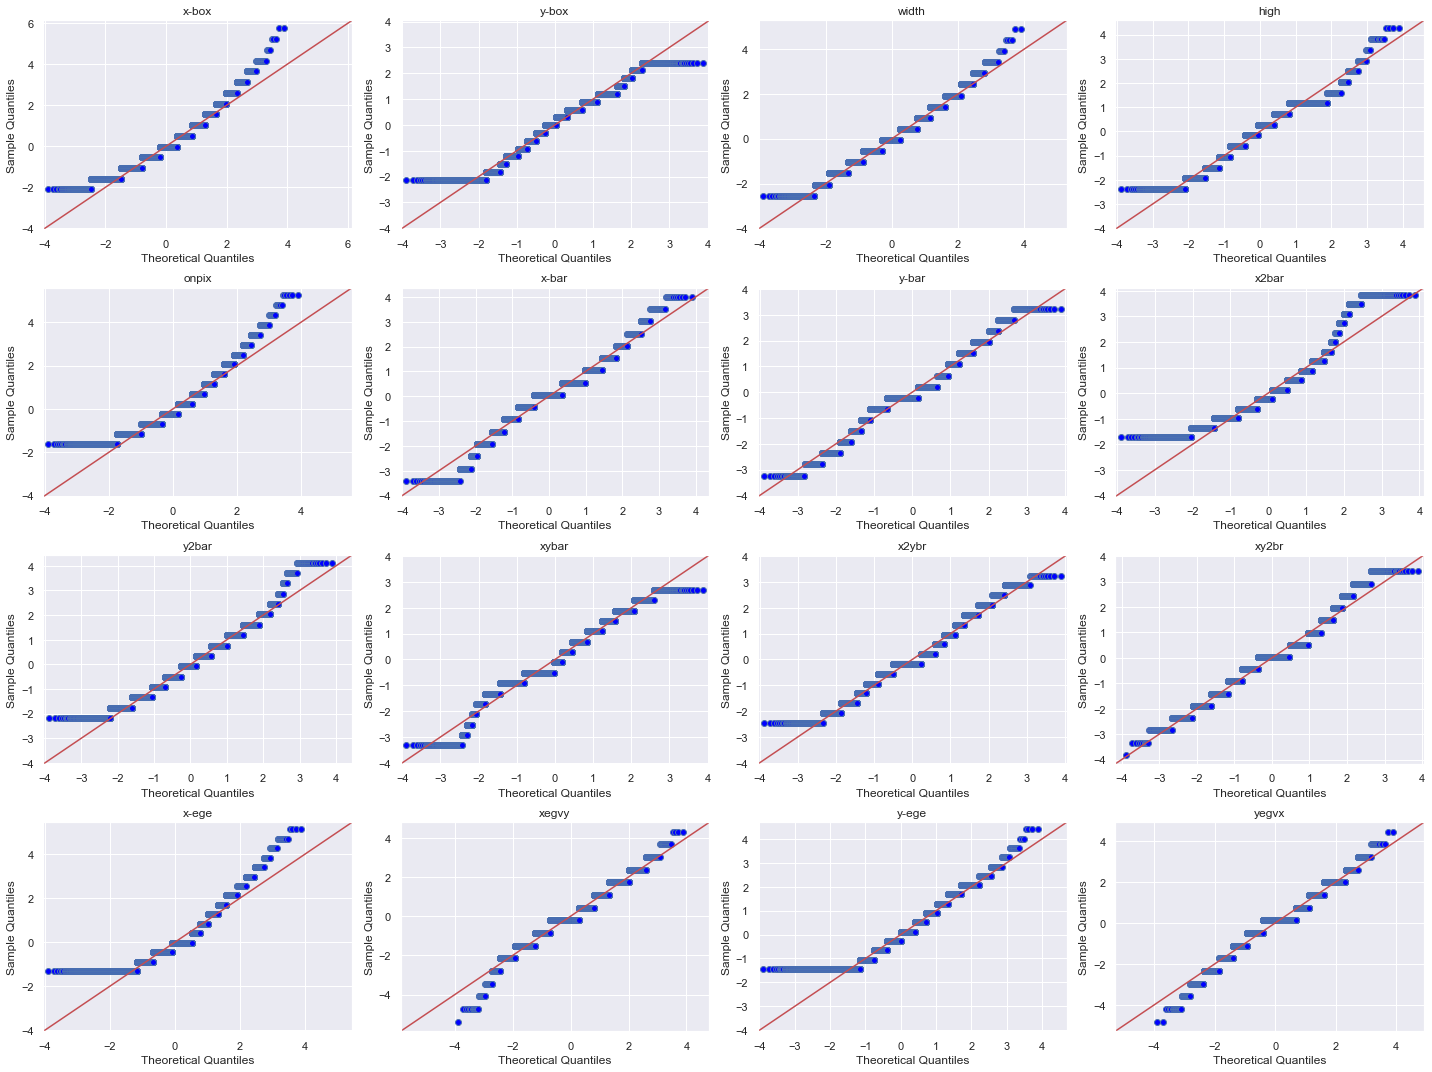

In [8]:
fig,axes = plt.subplots(4,4, figsize=(20,15))
ax = axes.flatten()
for i in range(1,17,1):
    sm.qqplot((df.iloc[:,i]), line='45', ax=ax[i-1])
    ax[i-1].title.set_text(column_names[i])
fig.tight_layout()

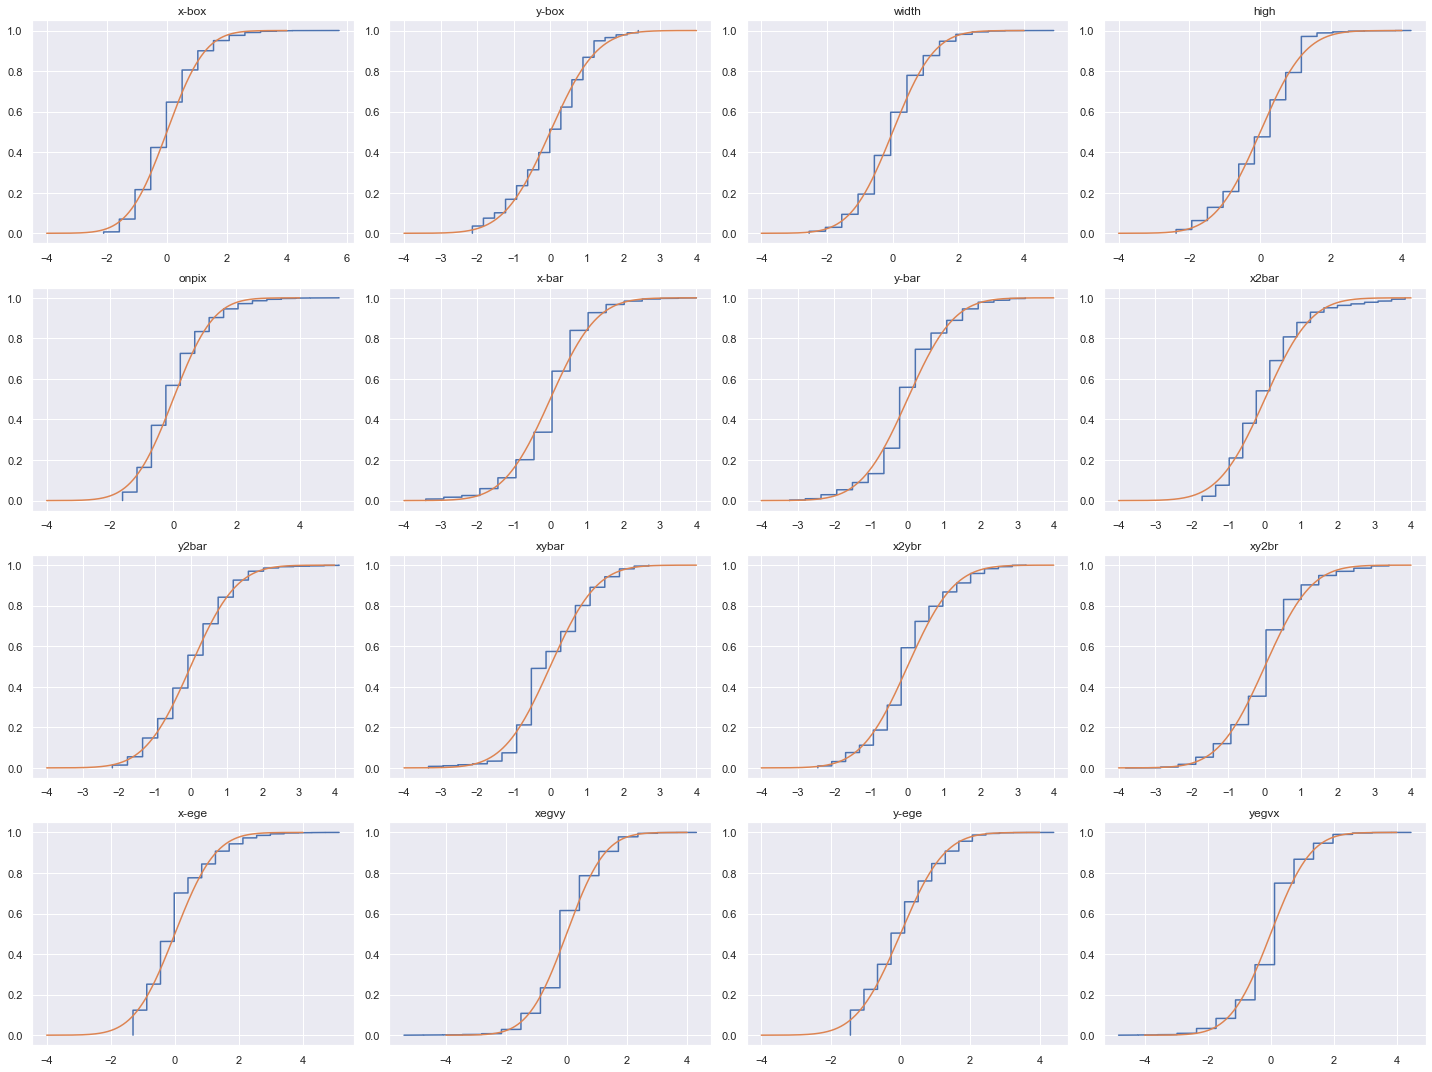

In [9]:
x = np.linspace(-4, 4, 1000)
y = stats.norm.cdf(x)

fig,axes = plt.subplots(4,4, figsize=(20,15))
ax = axes.flatten()
for i in range(1,17,1):
    ecdf = ECDF(df.iloc[:,i])
    ax[i-1].plot(ecdf.x, ecdf.y)
    ax[i-1].plot(x, y)
    ax[i-1].title.set_text(column_names[i])
    
fig.tight_layout()

In [10]:
# Run the Anderson-Darling test for normality on every independent variable
for i in range(1, 17, 1):
    print(column_names[i], ': ', stats.anderson(df.iloc[:, i], 'norm'))

x-box :  AndersonResult(statistic=333.9437564900836, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
y-box :  AndersonResult(statistic=180.2923299862632, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
width :  AndersonResult(statistic=227.65242446771663, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
high :  AndersonResult(statistic=304.22943987791587, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
onpix :  AndersonResult(statistic=406.5749096551226, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
x-bar :  AndersonResult(statistic=432.27869756530345, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. 

<AxesSubplot:>

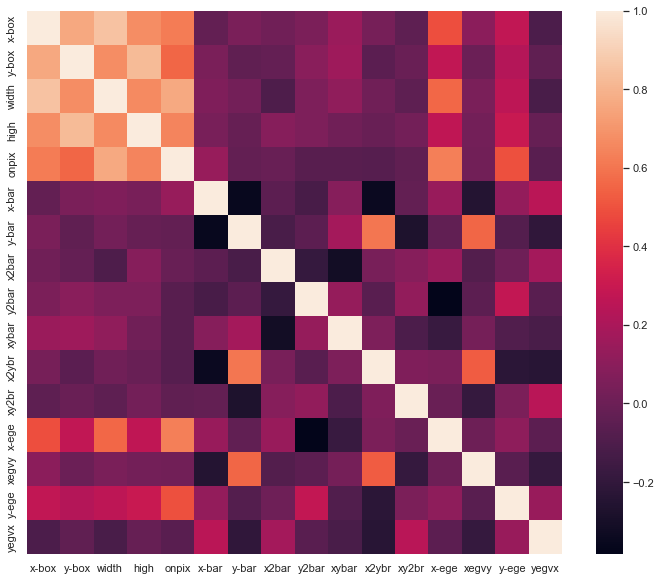

In [11]:
# Generate the correlation matrix
corrmx = df.corr()

# Plot the correlation matrix as a heatmap
%matplotlib inline
plt.figure(figsize=(12,10))
sns.heatmap(corrmx, xticklabels=corrmx.columns, yticklabels=corrmx.columns)

We can note that there is no missing data (every attribute has 20,000) non-null values. There is a sufficiently large amount of data to theoretically obtain good results. There is a narrow range of counts (79) and only ~22 standard deviation. Some variables (x-bar, y-bar, y2bar, x2ybr, xy2br, xegvy, yegvx) seem to have a normal distribution, but other look right or left tailed. This will be something to consider when using Gaussian NB.

# Modelling the data

We will define a function to find the median of a list. We will train and test each model 5 times in a for loop and store the median training and prediction times in dictionaries for access in the analysis.

In [12]:
# Utility function to find the median of a list
def median(ls):
    ls.sort()
    return ls[int(np.floor(len(ls) / 2))]

# Use dictionaries to store results
training_times = {} # Store training times for each model
prediction_times = {} # Store prediction times for each model
accuracy_scores = {} # Store accuracy scores for each model

## Creating the training and testing sets

In [13]:
# Set desired training set size
# 1 <= N <= 19999
train_size = 16000

In [14]:
# Find the indices for training and testing sets
random_indices = np.random.permutation(len(df))
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:]

# Split the data into training and testing tests
df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

# Create the training/testing inputs and labels
train_X, train_y = df_train.iloc[:, 1 :len(df_train.columns)], df_train.iloc[:,0]
test_X, test_y = df_test.iloc[:, 1 :len(df_test.columns)], df_test.iloc[:,0]

## Multinomial logistic regression

In [15]:
# Tune the inverse of regularisation strength for L2 regularisation
params = {"C":np.logspace(-3,3,20)}
lr = LogisticRegression(multi_class='ovr', solver='newton-cg', penalty='l2', max_iter=100)
grid_lr = GridSearchCV(lr, params)
grid_lr.fit(train_X, train_y)
best_C = grid_lr.best_params_.get('C') # Get the best value of C
print(best_C)

2.976351441631316


In [16]:
# Create and validate the model
lr = LogisticRegression(multi_class='ovr', solver='newton-cg', penalty='l2', max_iter=100, C=best_C) # LR model with best C
print(np.mean(cross_val_score(lr, train_X, train_y, cv=5))) # 5-fold cross validation

0.7225


In [17]:
# Train the LR model
lr_train_times = []
for i in range(5):
    start = time.time()
    lr.fit(train_X, train_y)
    stop = time.time()
    lr_train_times.append(stop - start)
training_times['Multinomial logistic regression'] = median(lr_train_times)

# Predict on the testing set with LR model
lr_pred_times = []
for i in range(5):
    start = time.time()
    lr_pred = lr.predict(test_X)
    stop = time.time()
    lr_pred_times.append(stop - start)
prediction_times['Multinomial logistic regression'] = median(lr_pred_times)
accuracy_scores['Multinomial logistic regression'] = metrics.accuracy_score(test_y, lr_pred)
print('Accuracy score: ', accuracy_scores.get('Multinomial logistic regression'))

Accuracy score:  0.72625


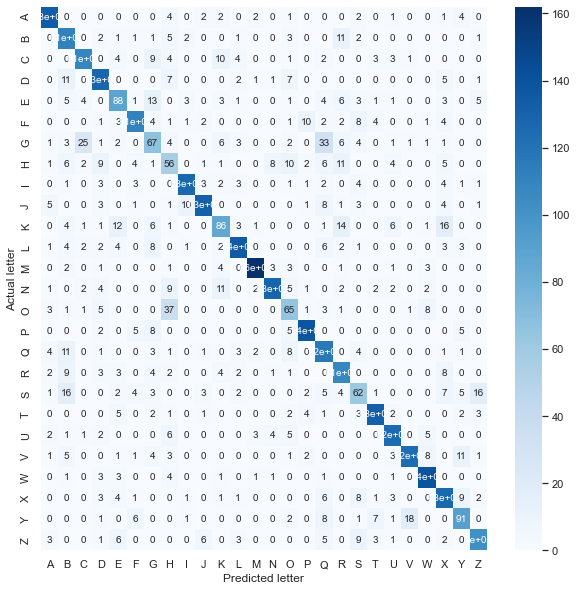

In [18]:
# Plot a confusion matrix
lr_confmx = metrics.confusion_matrix(test_y, lr_pred, labels=lr.classes_)

%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(lr_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(lr.classes_)
ax.yaxis.set_ticklabels(lr.classes_)
plt.show()

## Gaussian Naive-Bayes

In [19]:
# Create and validate the Gaussian Naive-Bayes model
nb = naive_bayes.GaussianNB()
print(np.mean(cross_val_score(nb, train_X, train_y, cv=5))) # 5-fold cross validation 

0.6351875


In [20]:
# Train the Gaussian NB model
nb_train_times = []
for i in range(5):
    start = time.time()
    nb.fit(train_X, train_y)
    stop = time.time()
    nb_train_times.append(stop - start)
training_times['Gaussian Naive-Bayes'] = median(nb_train_times)

# Predict on testing set with Gaussian NB model
nb_pred_times = []
for i in range(5):
    start = time.time()
    nb_pred = nb.predict(test_X)
    stop = time.time()
    nb_pred_times.append(stop - start)
prediction_times['Gaussian Naive-Bayes'] = median(nb_pred_times)
accuracy_scores['Gaussian Naive-Bayes'] = metrics.accuracy_score(test_y, nb_pred)
print('Accuracy score: ', accuracy_scores.get('Gaussian Naive-Bayes'))

Accuracy score:  0.64775


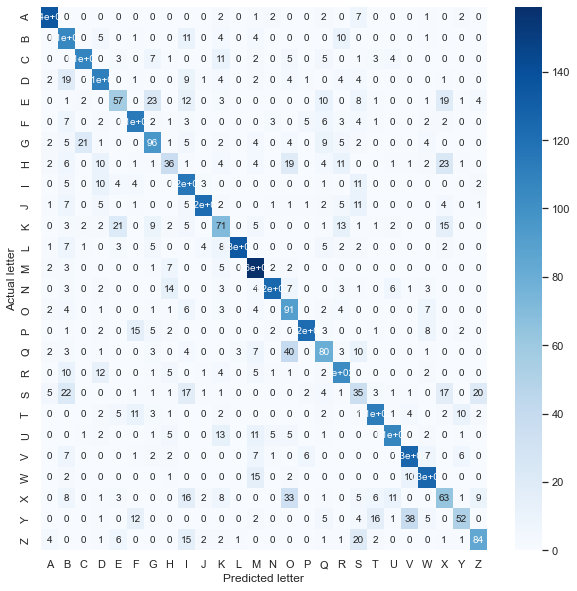

In [21]:
# Plot a confusion matrix
nb_confmx = metrics.confusion_matrix(test_y, nb_pred, labels=nb.classes_)
%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(nb_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(nb.classes_)
ax.yaxis.set_ticklabels(nb.classes_)
plt.show()

### Removing highly correlated covariates

Now we will remove the first five explanatory variables, in attempt to reduce correlation between covariates.

In [22]:
# Dropping highly correlated variables from  training and testing set
train_X_2 = train_X.drop(['x-box', 'y-box', 'width', 'high', 'onpix'], axis=1)
test_X_2 = test_X.drop(['x-box', 'y-box', 'width', 'high', 'onpix'], axis=1)

In [23]:
# Validate the model on the new training and testing sets
print(np.mean(cross_val_score(nb, train_X_2, train_y, cv=5))) # 5-fold cross validation 

0.6547500000000002


In [24]:
# Replace the previous times/scores for Naive-Bayes

# Train the Gaussian NB model with the new training set
nb_train_times = []
for i in range(5):
    start = time.time()
    nb.fit(train_X_2, train_y)
    stop = time.time()
    nb_train_times.append(stop - start)
training_times['Gaussian Naive-Bayes'] = median(nb_train_times) 

# Predict on the testing set with Gaussian NB model
nb_pred_times = []
for i in range(5):
    start = time.time()
    nb_pred2 = nb.predict(test_X_2)
    stop = time.time()
    nb_pred_times.append(stop - start)
prediction_times['Gaussian Naive-Bayes'] = median(nb_pred_times) 
accuracy_scores['Gaussian Naive-Bayes'] = metrics.accuracy_score(test_y, nb_pred2) 
print('Accuracy score: ', accuracy_scores.get('Gaussian Naive-Bayes')) 

Accuracy score:  0.66675


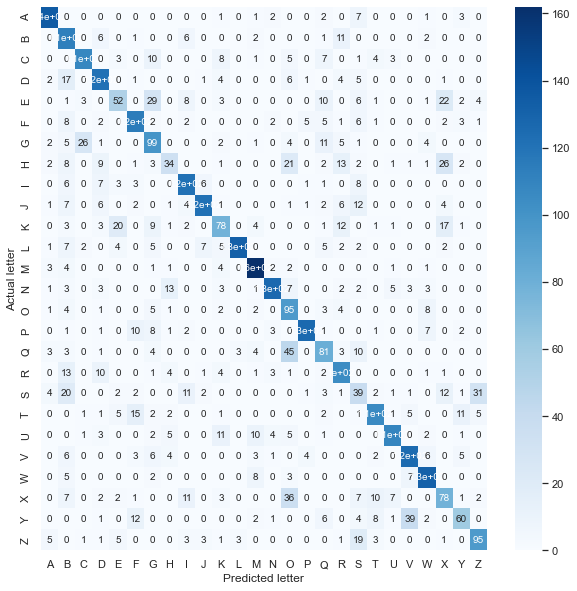

In [25]:
# Plot a confusion matrix
nb_confmx2 = metrics.confusion_matrix(test_y, nb_pred2, labels=nb.classes_)

%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(nb_confmx2, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(nb.classes_)
ax.yaxis.set_ticklabels(nb.classes_)
plt.show()

## K-Nearest-Neighbours

In [26]:
# Identify the best value of K
params = {'n_neighbors': np.arange(1,11,1)}
knn = KNeighborsClassifier() # Create the model
grid_knn = GridSearchCV(knn, params)
grid_knn.fit(train_X, train_y)
print(grid_knn.best_params_)

{'n_neighbors': 1}


In [27]:
# Validate the model
knn = KNeighborsClassifier(n_neighbors=1)
print(np.mean(cross_val_score(knn, train_X, train_y, cv=5)))

0.9440624999999999


\>90% accuracy is impressive. We will find the accuracy on the testing set.

In [28]:
# Train the 1NN model 
knn_train_times = []
for i in range(5):
    start = time.time()
    knn.fit(train_X, train_y)
    stop = time.time()
    knn_train_times.append(stop - start)
training_times['1-nearest neighbour'] = median(knn_train_times)

# Predict on the testing set with 1NN model
knn_pred_times = []
for i in range(5):
    start = time.time()
    knn_pred = knn.predict(test_X)
    stop = time.time()
    knn_pred_times.append(stop - start)
prediction_times['1-nearest neighbour'] = median(knn_pred_times)
accuracy_scores['1-nearest neighbour'] = metrics.accuracy_score(test_y, knn_pred)
print('Accuracy score: ', accuracy_scores.get('1-nearest neighbour'))

Accuracy score:  0.957


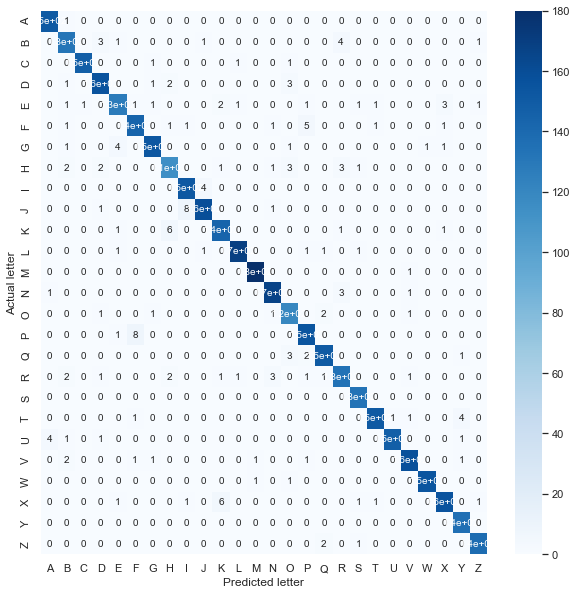

In [29]:
# Plot a confusion matrix
knn_confmx = metrics.confusion_matrix(test_y, knn_pred, labels=knn.classes_)
%matplotlib inline
plt.figure(figsize=(10,10))
ax = sns.heatmap(knn_confmx, annot=True, cmap='Blues')
plt.xlabel('Predicted letter')
plt.ylabel('Actual letter')
ax.xaxis.set_ticklabels(knn.classes_)
ax.yaxis.set_ticklabels(knn.classes_)
plt.show()

## Neural networks

### Preparing the data

We'll begin by converting our data labels to one-hot encodings, as Keras does not do this for us automatically. We'll then convert the data to numpy arrays as these are simple to work with and can be fed straight to Keras neural networks.

In [30]:
# One-hot encode the training and testing sets for use as tensors in 
# our neural networks
train_onehot_labels = pd.get_dummies(train_y)
test_onehot_labels = pd.get_dummies(test_y)

In [31]:
# Convert the data to arrays
train_inputs = train_X.to_numpy()
train_labels = train_onehot_labels.to_numpy()
test_inputs = test_X.to_numpy()
test_labels = test_onehot_labels.to_numpy()

### Model validation

#### Baseline model

We shall begin by creating a relatively small neural network to serve as our baseline. We will compare this against models with larger numbers of hidden neurons and using regularisation. We've chosen two hidden layers, each with 20 neurons (chosen as a round number between 16 and 26). We'll use 5-fold cross-validation to compare the categorical cross-entropy loss of the models.

In [32]:
# Compiling a baseline network to compare networks to.
# We have used the He initialization method, Adam optimization
# and categorical cross-entropy loss function
base_model = models.Sequential()
base_model.add(layers.Dense(20, activation='relu', input_shape=(16,), 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.add(layers.Dense(20, activation='relu', 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.add(layers.Dense(26, activation='softmax', 
                            kernel_initializer='he_normal', bias_initializer='Zeros'))
base_model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
base_model.save_weights('initial_weights1') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                            # cross-validation)

Average accuracy on validation set:  0.8724375009536743


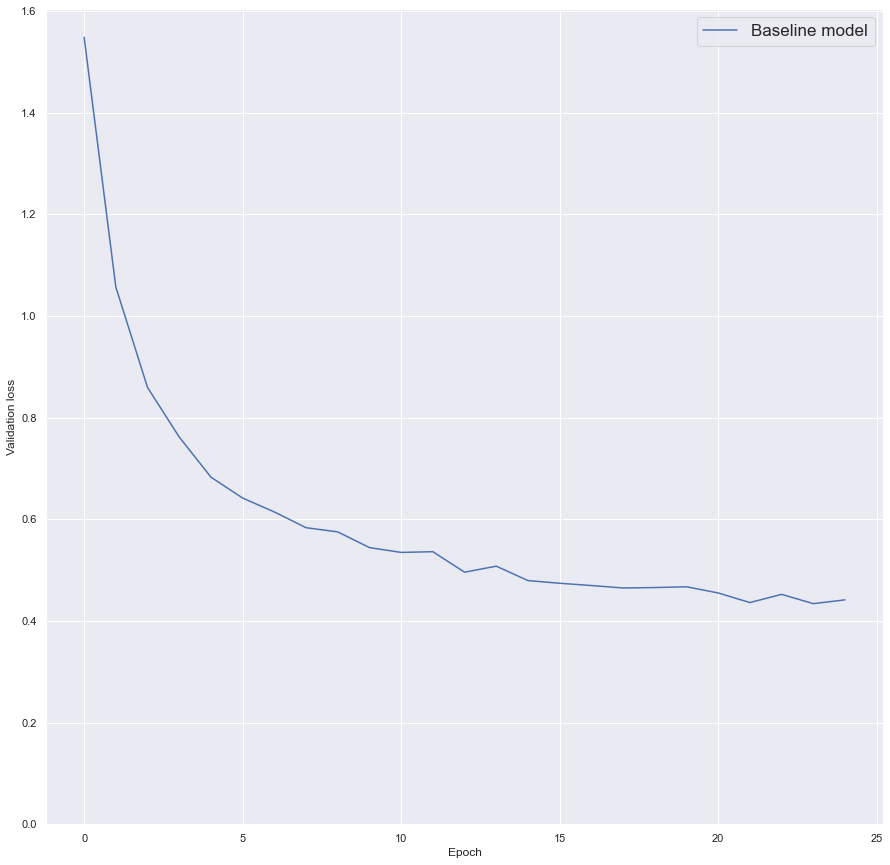

In [33]:
# Training the network with K-fold cross-validation
k = 5
validation_size = len(train_X) // k
validation_loss1 = []
validation_accuracy1 = []
for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]
    
    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)
    
    # Train the model
    # Reset the weights and biases after each fold
    base_model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', metrics=['accuracy'])
    history = base_model.fit(partial_train_inputs, partial_train_labels, 
                   validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss1.append(history.history['val_loss'])
    validation_accuracy1.append(history.history['val_accuracy'][24])
    base_model.load_weights('initial_weights1')
    
# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy1))

# Plot validation loss vs epoch
epochs = np.linspace(0,24,25)
val_loss1_1 = validation_loss1[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

#### Higher capacity model

In [34]:
# Create a model with a higher number of neurons in each layer.
model2 = models.Sequential()
model2.add(layers.Dense(100, activation='relu', input_shape=(16,), 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model2.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model2.save_weights('initial_weights2') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9461874961853027


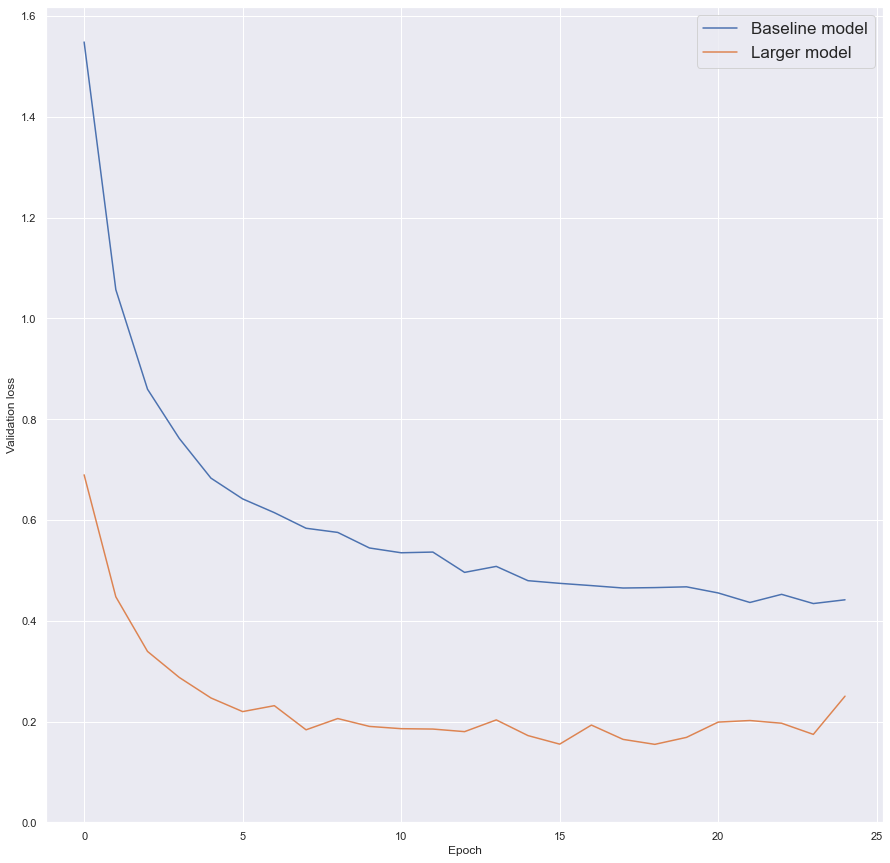

In [35]:
# Training the network with 5-fold cross-validation
validation_loss2 = []
validation_accuracy2 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model2.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model2.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss2.append(history.history['val_loss'])
    validation_accuracy2.append(history.history['val_accuracy'][24])
    model2.load_weights('initial_weights2')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy2))

# Plot validation loss vs epoch
val_loss2_1 = validation_loss2[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

#### Regularising the model

In [36]:
# Add L2 regularisation to the model from the previous section.
model3 = models.Sequential()
model3.add(layers.Dense(100, activation='relu', input_shape=(16,), 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros',
                       kernel_regularizer=l2(0.001)))
model3.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model3.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model3.save_weights('initial_weights3') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9408125042915344


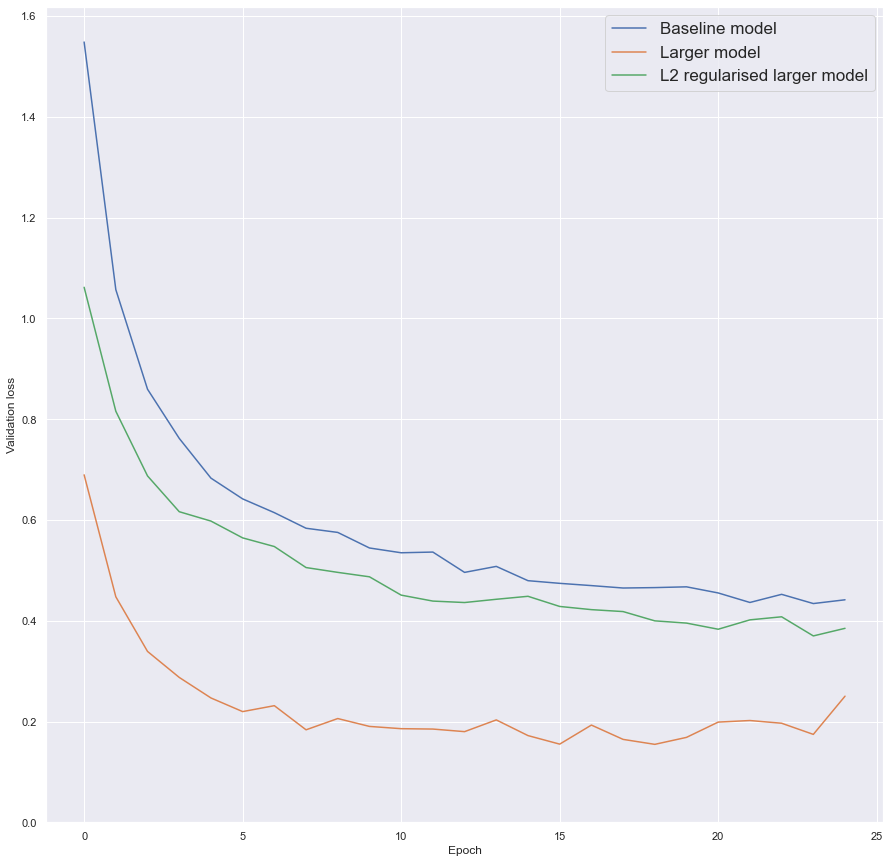

In [37]:
# Training the network with 5-fold cross-validation
validation_loss3 = []
validation_accuracy3 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model3.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model3.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss3.append(history.history['val_loss'])
    validation_accuracy3.append(history.history['val_accuracy'][24])
    model3.load_weights('initial_weights3')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy3))

# Plot validation loss vs epoch
val_loss3_1 = validation_loss3[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.plot(epochs, val_loss3_1, label = 'L2 regularised larger model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

In [38]:
model4 = models.Sequential()
model4.add(layers.Dropout(0.01, input_shape=(16,)))
model4.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model4.add(layers.Dropout(0.4))
model4.add(layers.Dense(100, activation='relu', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model4.add(layers.Dropout(0.4))
model4.add(layers.Dense(26, activation='softmax', 
                       kernel_initializer='he_normal', bias_initializer='Zeros'))
model4.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model4.save_weights('initial_weights4') # Save the initial weights so we may reset the model when required (i.e. K-fold
                                        # cross-validation)

Average accuracy on validation set:  0.9408125042915344


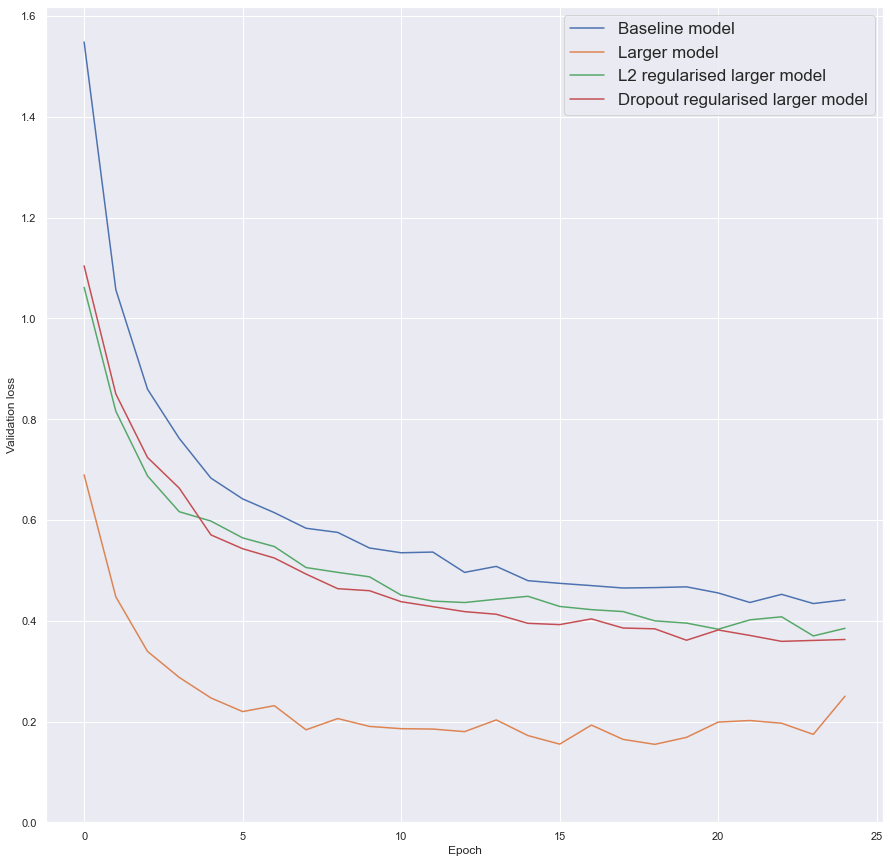

In [39]:
# Training the network with 5-fold cross-validation
validation_loss4 = []
validation_accuracy4 = []

for i in range(k):
    # Prepare the validation set
    val_inputs = train_inputs[i * validation_size : (i + 1) * validation_size]
    val_labels = train_labels[i * validation_size : (i + 1) * validation_size]

    # Prepare the partial training set
    partial_train_inputs = np.concatenate([train_inputs[:i * validation_size],
                                           train_inputs[(i + 1) * validation_size:]], axis=0)
    partial_train_labels = np.concatenate([train_labels[:i * validation_size],
                                           train_labels[(i + 1) * validation_size:]], axis=0)

    # Train the model
    # Reset the weights and biases after each fold
    model4.compile(optimizer=Adam(learning_rate=0.01), 
                   loss='categorical_crossentropy', metrics=['accuracy'])
    history = model4.fit(partial_train_inputs, partial_train_labels, 
                         validation_data=(val_inputs, val_labels), epochs=25, batch_size=256, verbose=0)
    validation_loss4.append(history.history['val_loss'])
    validation_accuracy4.append(history.history['val_accuracy'][24])
    model4.load_weights('initial_weights4')

# Print the average accuracy on the cross-validation set
print('Average accuracy on validation set: ', np.mean(validation_accuracy3))

# Plot validation loss vs epoch
val_loss4_1 = validation_loss4[0] # The validation loss in each epoch in the first fold
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.plot(epochs, val_loss1_1, label='Baseline model')
ax.plot(epochs, val_loss2_1, label = 'Larger model')
ax.plot(epochs, val_loss3_1, label = 'L2 regularised larger model')
ax.plot(epochs, val_loss4_1, label = 'Dropout regularised larger model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.set_ylim(0,)
ax.legend(fontsize=17)

### Evaluating the neural networks

In [40]:
# Fit the unregularised NN
nn1_train_times = []
for i in range(5):
    start = time.time()
    model2.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
    stop = time.time()
    nn1_train_times.append(stop - start)
training_times['Unregularised neural network'] = median(nn1_train_times)

# Predict on the testing set with the unregularised NN
nn1_pred_times = []
for i in range(5):
    start = time.time()
    _, accuracy_scores['Unregularised neural network'] = model2.evaluate(test_inputs, test_labels)
    stop = time.time()
    nn1_pred_times.append(stop - start)
prediction_times['Unregularised neural network'] = median(nn1_pred_times)

125/125 [==============================] - 0s 638us/step - loss: 0.1989 - accuracy: 0.9715


In [41]:
# Fit the L2 regularised NN
nn2_train_times = []
for i in range(5):
    start = time.time()
    model3.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
    stop = time.time()
    nn2_train_times.append(stop - start)
training_times['L2 regularised neural network'] = median(nn2_train_times)

# Predict on the testing set with the unregularised NN
nn2_pred_times = []
for i in range(5):
    start = time.time()
    _, accuracy_scores['L2 regularised neural network'] = model3.evaluate(test_inputs, test_labels)
    stop = time.time()
    nn2_pred_times.append(stop - start)
prediction_times['L2 regularised neural network'] = median(nn2_pred_times)

125/125 [==============================] - 0s 614us/step - loss: 0.2957 - accuracy: 0.9425


In [42]:
# Fit the drop out regularised NN
nn3_train_times = []
for i in range(5):
    start = time.time()
    model4.fit(train_inputs, train_labels, epochs=25, batch_size=256, verbose=0)
    stop = time.time()
    nn3_train_times.append(stop - start)
training_times['Dropout regularised neural network'] = median(nn3_train_times)

# Predict on the testing set with the unregularised NN
nn3_pred_times = []
for i in range(5):
    start = time.time()
    _, accuracy_scores['Dropout regularised neural network'] = model4.evaluate(test_inputs, test_labels)
    stop = time.time()
    nn3_pred_times.append(stop - start)
prediction_times['Dropout regularised neural network'] = median(nn3_pred_times)

125/125 [==============================] - 0s 631us/step - loss: 0.2614 - accuracy: 0.9187


# Results

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

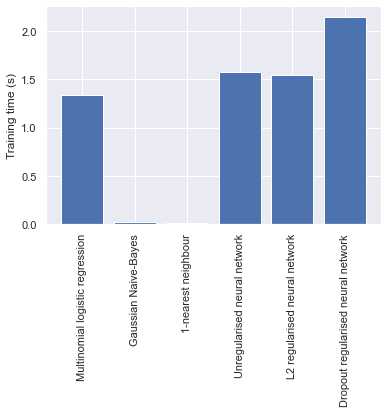

In [43]:
plt.bar(training_times.keys(), training_times.values())
plt.ylabel('Training time (s)')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

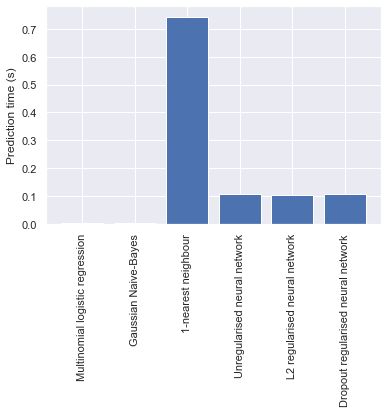

In [44]:
plt.bar(prediction_times.keys(), prediction_times.values())
plt.ylabel('Prediction time (s)')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

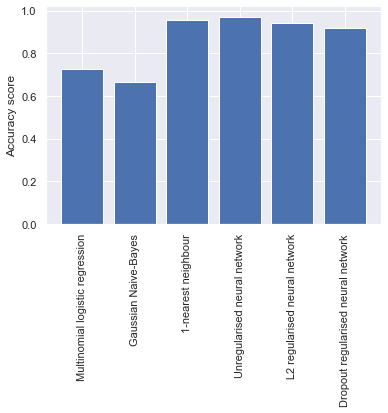

In [45]:
plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.ylabel('Accuracy score')
plt.xticks(rotation=90)

In [46]:
print('Training times')
for (key, value) in training_times.items():
    print(key, ': ', value)

Training times
Multinomial logistic regression :  1.341407299041748
Gaussian Naive-Bayes :  0.01969122886657715
1-nearest neighbour :  0.009003400802612305
Unregularised neural network :  1.5760154724121094
L2 regularised neural network :  1.5488934516906738
Dropout regularised neural network :  2.1519830226898193


In [47]:
print('Prediction times')
for (key, value) in prediction_times.items():
    print(key, ': ', value)

Prediction times
Multinomial logistic regression :  0.002079486846923828
Gaussian Naive-Bayes :  0.003912210464477539
1-nearest neighbour :  0.7439560890197754
Unregularised neural network :  0.10792422294616699
L2 regularised neural network :  0.10372185707092285
Dropout regularised neural network :  0.10590481758117676


In [48]:
print('Accuracy')
for (key, value) in accuracy_scores.items():
    print(key, ': ', value*100)

Accuracy
Multinomial logistic regression :  72.625
Gaussian Naive-Bayes :  66.675
1-nearest neighbour :  95.7
Unregularised neural network :  97.14999794960022
L2 regularised neural network :  94.24999952316284
Dropout regularised neural network :  91.8749988079071
